# Libraries

In [1]:
# Standards
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# Boosted Decision Tree (BDT)
import lightgbm as lgb
from verstack import LGBMTuner

# Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import RocCurveDisplay

2024-08-16 11:23:07.985837: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 11:23:08.072083: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-16 11:23:08.072119: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-16 11:23:08.072158: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-16 11:23:08.081655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-16 11:23:08.082606: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
#Simple timer for LGBM

import time
class Timer:
    def __init__(self,every=100):
        self.start = time.time()
        self.every = every
        
    def __call__(self,CallbackEnv):
        i = CallbackEnv.iteration
        if i%self.every == 0:
            print(f"Iteration: {i}")
            self.print_time()
            
    def print_time(self):
        print(f"Total time elapsed: {time.time()-self.start:.2f}s")

# Prework

## Loading data

In [4]:
data_all = pd.read_hdf("ATLAS_electrons.h5").sample(50_000)
display(data_all)

,averageInteractionsPerCrossing,p_Rhad1,p_Rhad,p_f3,p_weta2,p_Rphi,p_Reta,p_Eratio,p_f1,p_TRTPID,...,pX_E7x11_Lr2,pX_E7x11_Lr3,pX_E7x7_Lr0,pX_E7x7_Lr1,p_pt_track,p_eta,p_phi,p_charge,p_Truth_isElectron,p_Truth_Energy
112524,30.500000,0.140942,0.148596,0.054761,0.010062,0.905881,0.909372,0.046025,0.011576,0.009512,...,28420.568359,2354.186035,1610.739624,1475.453613,34111.601562,1.224245,2.655667,-1.0,0,61726.367188
63804,50.500000,0.379884,0.676033,0.030445,0.015100,0.816360,0.900805,0.321863,0.223081,-0.048802,...,65398.550781,3181.611816,9422.065430,23135.955078,7072.704102,-1.586827,2.568778,-1.0,0,-999.000000
492,24.500000,-0.003177,-0.002492,0.007655,0.010875,0.868309,0.944104,0.955241,0.307474,0.024585,...,27126.703125,-28.854471,1068.469727,12330.149414,32380.677734,-0.319043,-1.735978,-1.0,1,42446.105469
90727,58.500000,-0.070045,-0.061816,0.005156,0.007375,0.976180,0.949614,0.678775,0.261690,-0.079029,...,10205.655273,243.533539,454.990387,3247.079834,4281.206543,0.425582,2.415384,-1.0,0,13787.837891
88458,32.500000,0.240062,0.257281,0.008812,0.010967,0.953766,0.942934,0.966802,0.240825,-0.087048,...,71449.070312,1416.758179,12492.708984,26541.230469,3126.096680,1.338570,2.961691,1.0,0,6006.581543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118046,27.500000,0.015360,0.390383,0.096351,0.013735,0.794828,0.725075,0.081969,0.005857,-0.074533,...,43651.363281,8347.010742,3394.071533,10396.589844,13265.209961,1.120887,-1.511296,-1.0,0,22388.699219
78609,47.490002,0.024367,0.112164,0.022875,0.012113,0.838996,0.544952,0.298163,0.108259,-0.109971,...,33453.628906,6570.584961,2382.589111,3789.987305,14691.026367,-0.733619,-1.876860,1.0,0,17800.164062
20761,32.500000,0.001597,0.001704,0.000000,0.021797,0.956981,0.990680,0.000000,0.000000,0.568608,...,44022.593750,-73.948822,8134.506836,15637.342773,34765.781250,1.419259,0.116001,-1.0,1,85173.546875
144311,24.500000,0.498528,0.603516,0.058890,0.007766,0.672673,0.716427,0.871517,0.169446,-0.136971,...,16767.583984,1066.673462,867.663269,6279.370605,15634.318359,-0.185810,0.477237,-1.0,0,15632.729492


## Split data into labels and features

In [5]:
best_features = ['p_Rhad','p_sigmad0','p_TRTPID','p_deltaEta1','p_etcone20','p_numberOfInnermostPixelHits',
                 'p_Rhad1','pX_f3core','p_dPOverP','p_d0','pX_E3x5_Lr1','p_deltaPhiRescaled2','pX_deltaEta2',
                 'p_Reta','pX_topoetcone20','p_etcone30','pX_MultiLepton','p_Eratio','p_f3','pX_topoetcone40'][:10]

yelectron = data_all.pop("p_Truth_isElectron")
yenergy = data_all.pop("p_Truth_Energy")
X = data_all[best_features]

# Classification

First we split the data into training, validation, and test sets.

In [6]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X,yelectron,
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,
                                            test_size=0.25,random_state=314)

## By hand

## LightGBM

In [7]:
param = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'unbalanced_sets': True,
    'num_leaves': 475,
    'learning_rate': 0.0127,
    'feature_fraction': 0.49,
    'bagging_fraction': 0.957,
    'bagging_freq': 29,
    'min_child_samples': 7,
}

lgb_model = lgb.LGBMClassifier(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10), timer:=Timer()])
timer.print_time()

[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957
[LightGBM] [Info] Number of positive: 8347, number of negative: 31653
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2298
[LightGBM] [Info]

[LightGBM] [Warning] feature_fraction is set=0.49, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49
[LightGBM] [Warning] bagging_freq is set=29, subsample_freq=0 will be ignored. Current value: bagging_freq=29
[LightGBM] [Warning] bagging_fraction is set=0.957, subsample=1.0 will be ignored. Current value: bagging_fraction=0.957


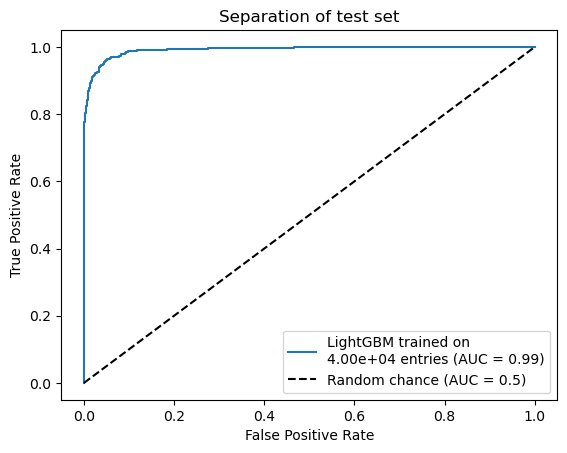

In [8]:
display_roc = RocCurveDisplay.from_predictions(
    ytest,
    ypred:= lgb_model.predict_proba(Xtest)[:,1],
    name=f"LightGBM trained on\n{len(ytrain):2.2e} entries",
)
display_roc.ax_.plot([0,1],[0,1],"k--",label="Random chance (AUC = 0.5)")
display_roc.ax_.legend()
_ = display_roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Separation of test set"
)

By inspecting the model, we see that not all features are equally important. We also see, that the model didn't get to overtrain.

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

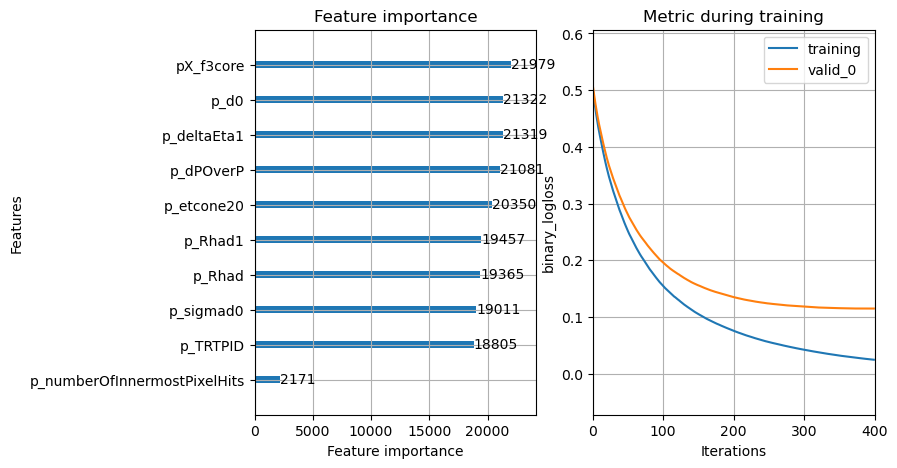

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(8,5))
lgb.plot_metric(lgb_model,ax=ax[1])
lgb.plot_importance(lgb_model,ax=ax[0],max_num_features=40)

## Verstack

In [10]:
tuner = LGBMTuner(metric="log_loss")


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: log_loss 
     .. Study direction: minimize log_loss

     . Trial number: 0 finished
     .. Optimization score (lower-better): log_loss: 0.10735747654338372
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): log_loss: 0.09794903341626643
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): log_loss: 0.09993168593216917
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): log_loss: 0.10241638028699881
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): log_loss: 0.11077709103226974
 .............

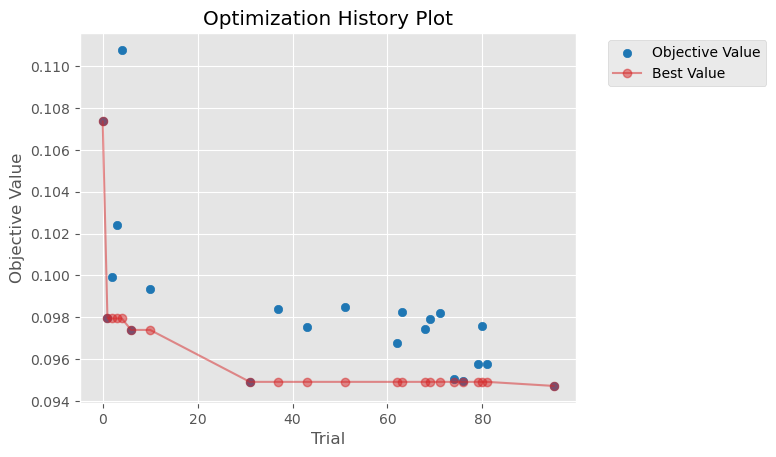

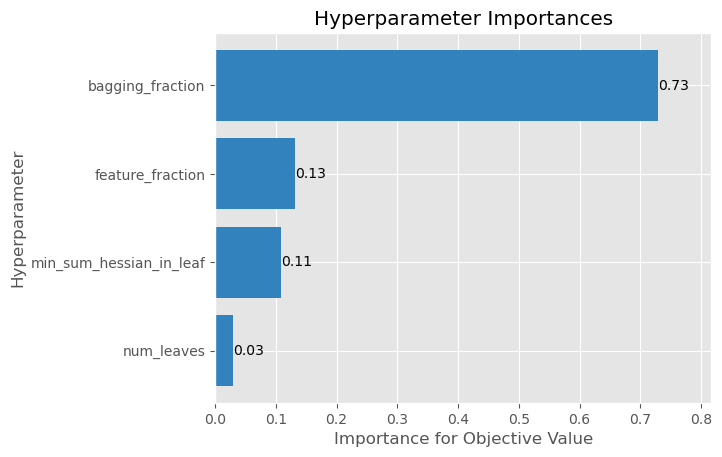

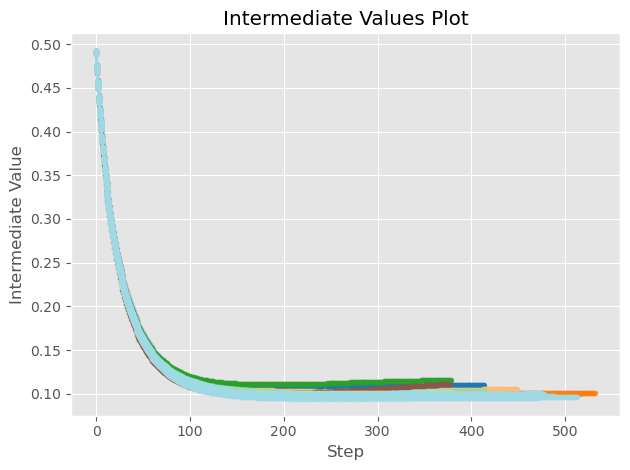

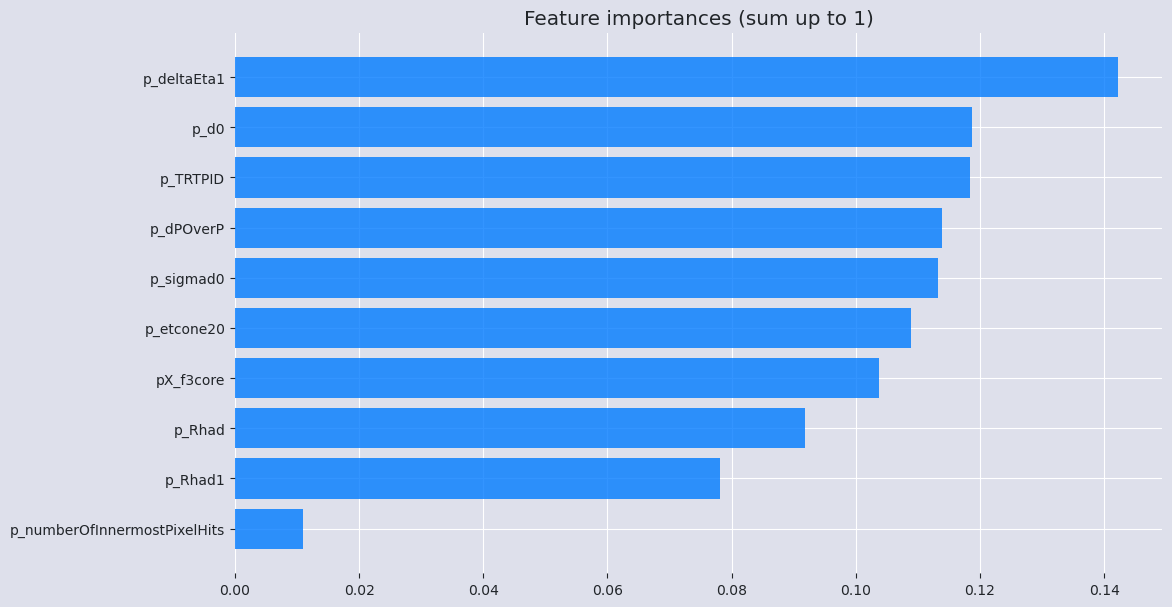


     . Optuna hyperparameters optimization finished
     .. Best trial number:95    |     log_loss:          0.09472373739996864
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 2 min 31.202 sec


In [11]:
tuner.fit(Xtrain,ytrain)

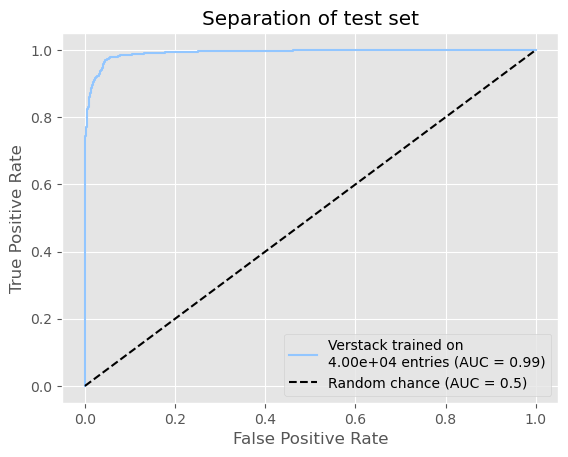

In [12]:
display_roc = RocCurveDisplay.from_predictions(
    ytest,
    ypred:= tuner.predict_proba(Xtest),
    name=f"Verstack trained on\n{len(ytrain):2.2e} entries",
)
display_roc.ax_.plot([0,1],[0,1],"k--",label="Random chance (AUC = 0.5)")
display_roc.ax_.legend()
_ = display_roc.ax_.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    title="Separation of test set"
)

# Regression

## By hand

# LightGBM

As before we start by separating the data into sets for training, testing, and validating.

In [13]:
Xtrain, Xrem, ytrain, yrem = train_test_split(X.loc[yelectron == 1],yenergy[yelectron==1], #Only train on particles that are actually electrons
                                              test_size=0.2,random_state=42)
Xval, Xtest, yval, ytest = train_test_split(Xrem,yrem,test_size=0.25,random_state=314)

In [14]:
param = {
    'objective': 'regression',
    'unbalanced_sets': True,
    'num_leaves': 298,
    'learning_rate': 0.045,
    'feature_fraction': 0.64,
    'bagging_fraction': 0.97,
    'bagging_freq': 5,
    'min_child_samples': 2,
}

lgb_model = lgb.LGBMRegressor(**param,n_estimators=1000, random_state=42)
lgb_model.fit(Xtrain, ytrain,eval_set=[(Xval,yval),(Xtrain,ytrain)],
             callbacks=[lgb.callback.early_stopping(stopping_rounds=10),timer:=Timer(every = 50)])

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000473 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2297
[LightGBM] [Info] Number of data points in the train set: 8395, number of used features: 10
[Li

LGBMRegressor(bagging_fraction=0.97, bagging_freq=5, feature_fraction=0.64,
              learning_rate=0.045, min_child_samples=2, n_estimators=1000,
              num_leaves=298, objective='regression', random_state=42,
              unbalanced_sets=True)

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

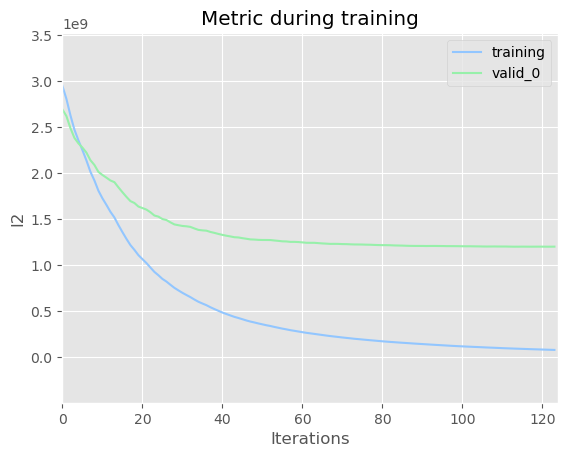

In [15]:
lgb.plot_metric(lgb_model)

In [16]:
energy_pred = lgb_model.predict(Xtest)

rel_dev = (energy_pred-ytest)/ytest

[LightGBM] [Warning] feature_fraction is set=0.64, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.64
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.97, subsample=1.0 will be ignored. Current value: bagging_fraction=0.97


[(-2.0, 5.0), Text(0, 0.5, 'Counts/525'), Text(0.5, 0, 'Relative deviation')]

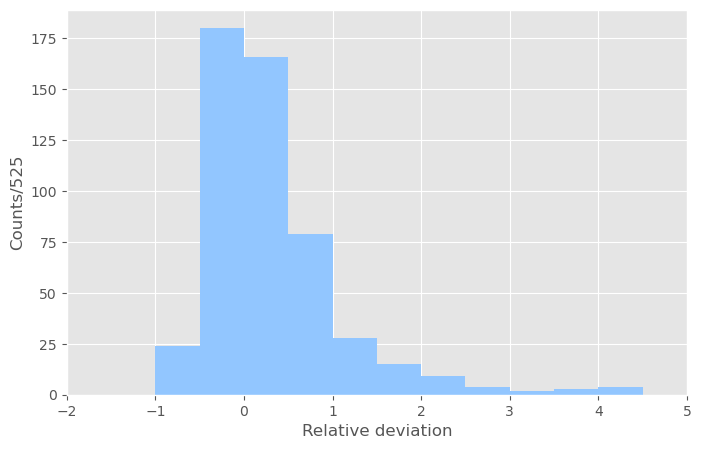

In [17]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
bins = np.linspace(-5,10,31)

xlabel = f"Relative deviation"
if largest:=np.min(rel_dev) > 5:
    bins[-1] = largest #Note that the last bin contains everything greater than 5
    xlabel += f" - Zoomed in from {bins[0]:.2f}"
    
ax.hist(rel_dev, bins = bins)
ax.set(xlim=(-2,5),
      ylabel=f"Counts/{len(ytest)}",
      xlabel=xlabel)

## Verstack

In [18]:
tuner = LGBMTuner(metric="rmse")


 * Initiating LGBMTuner.fit
     . Settings:
     .. Trying 100 trials
     .. Evaluation metric: rmse 
     .. Study direction: minimize rmse

     . Trial number: 0 finished
     .. Optimization score (lower-better): rmse: 35629.383088409784
 ...........................................................................
     . Trial number: 1 finished
     .. Optimization score (lower-better): rmse: 36934.09074132814
 ...........................................................................
     . Trial number: 2 finished
     .. Optimization score (lower-better): rmse: 33131.01767034124
 ...........................................................................
     . Trial number: 3 finished
     .. Optimization score (lower-better): rmse: 35112.24987174663
 ...........................................................................
     . Trial number: 4 finished
     .. Optimization score (lower-better): rmse: 36369.446195297256
 .................................................

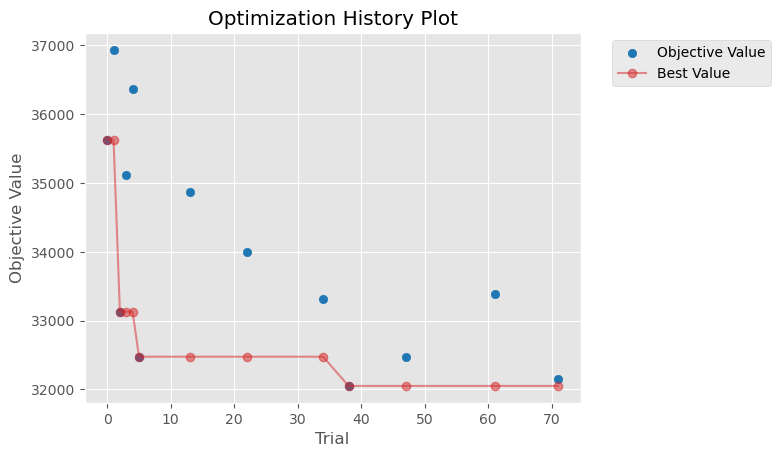

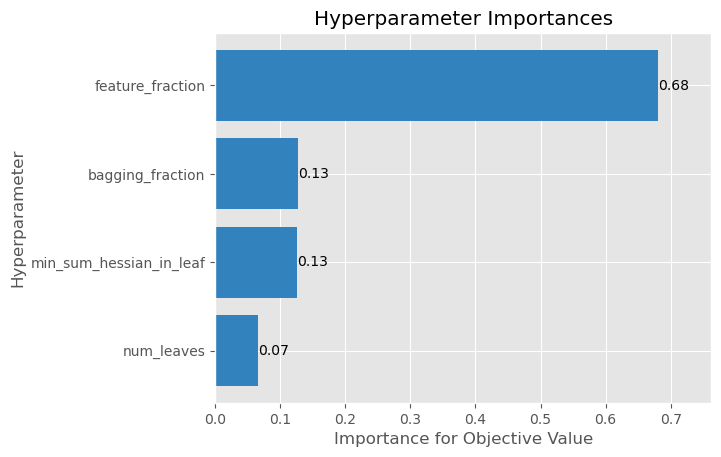

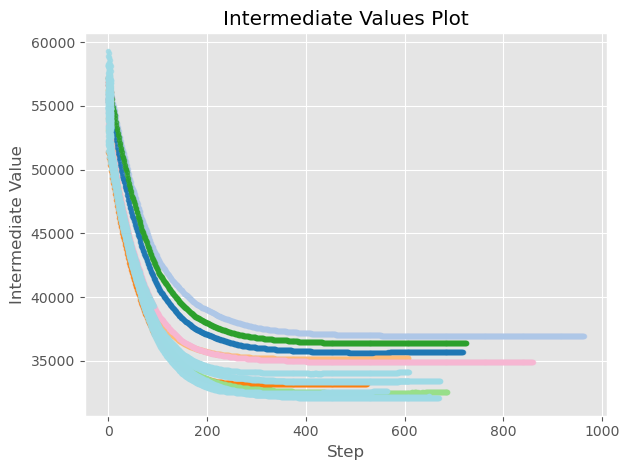

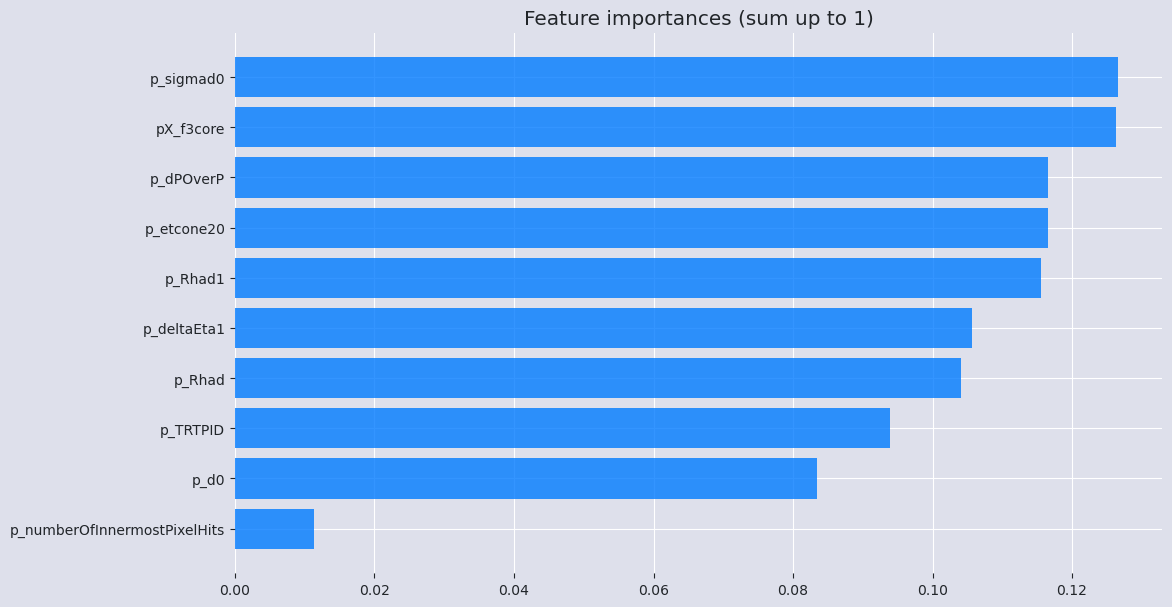


     . Optuna hyperparameters optimization finished
     .. Best trial number:38    |     rmse:           32051.863130079495
 ---------------------------------------------------------------------------

Time elapsed for fit execution: 1 min 1.234 sec


In [19]:
tuner.fit(Xtrain,ytrain)

In [20]:
energy_pred = tuner.predict(Xtest)

rel_dev = (energy_pred-ytest)/ytest

[(-2.0, 5.0), Text(0, 0.5, 'Counts/525'), Text(0.5, 0, 'Relative deviation')]

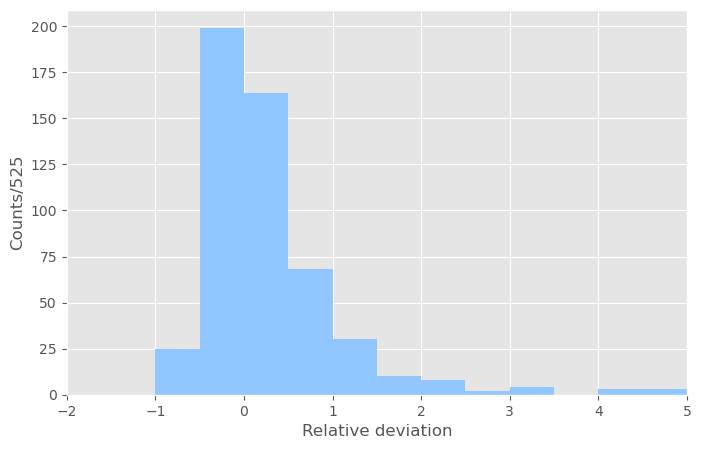

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,5))
bins = np.linspace(-5,10,31)

xlabel = f"Relative deviation"
if largest:=np.min(rel_dev) > 5:
    bins[-1] = largest #Note that the last bin contains everything greater than 5
    xlabel += f" - Zoomed in from {bins[0]:.2f}"
    
ax.hist(rel_dev, bins = bins)
ax.set(xlim=(-2,5),
      ylabel=f"Counts/{len(ytest)}",
      xlabel=xlabel)